In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import scipy.stats as stats
from scipy import interp
import statistics 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from statistics import mean 


from sklearn import metrics
from sklearn.metrics import auc
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut 


from xgboost.sklearn import XGBClassifier

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN # doctest: +NORMALIZE_WHITESPACE
import itertools
import copy

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

np.random.seed(100)

# df0 = pd.read_csv('Diabetes Project Part 2.csv')
# df = df0.copy(deep=True)
# df.head()

In [297]:
df = pd.read_csv('Diabetes Data.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df.head()

,Anemia,BMI,HDL,LDL,Pesticide Use,Age,Alcohol Use,Diabetes,Exercise,Fasting Glucose,...,Insulin_NaN,SysBP_NaN,DiaBP_NaN,Alcohol Use_NaN,Mexican American,Hispanic,White,Black,Asian,Other Race
0,0.0,-1.624450,1.814557,-0.288805,0.0,1.399115,-1.061516,0.0,1.0,0.377156,...,0,0,0,0,0,0,1,0,0,0
1,0.0,1.183858,0.284185,-0.416550,0.0,0.729447,-0.368968,0.0,1.0,0.574394,...,0,0,0,0,0,0,1,0,0,0
2,0.0,-1.482733,2.334568,-1.368495,0.0,-1.223751,-0.368968,0.0,1.0,-0.942001,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0.185727,-1.582470,0.282361,0.0,-0.888917,5.863966,0.0,0.0,0.173088,...,0,0,0,0,1,0,0,0,0,0
4,0.0,1.210246,0.082563,1.553668,0.0,-0.554083,-0.715242,0.0,0.0,0.104585,...,0,1,1,0,0,0,0,1,0,0


In [298]:
# y = df['Diabetes'].values
# X = df.drop(['Diabetes'],axis = 1).values
y = df['Diabetes']
X = df.drop(['Diabetes'],axis = 1)
X_names = df.drop(['Diabetes'],axis = 1).columns.tolist()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 2)


In [299]:
numerical_variables = ['BMI','HDL','LDL','Age','Alcohol Use','Fasting Glucose','Insulin','sysBP','diaBP',
                       'Leg Length','Waist Size']
categorical_variables = ['Mexican American','Hispanic','White','Black','Asian','Other Race',
                          'BMI_NaN','Fasting glucose_NaN','LDL_NaN','HDL_NaN','Insulin_NaN',
                          'SysBP_NaN','DiaBP_NaN','Alcohol Use_NaN',
                         'Gender', 'Exercise', 'Pesticide Use','Anemia']
feature_list = numerical_variables + categorical_variables
len(feature_list)


29

In [300]:
def plot_roc(y_val,y_val_predictions,best_clf,X_val):
    probability = best_clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_predictions)
    print('AUC: = %0.2f' % roc_auc)
    fpr, tpr, thresholds = roc_curve(y_val, probability)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - False alarm')
    plt.ylabel('True Positive Rate - Recall')
#     plt.title(clf_name + '  --  AUC: = %0.2f' % roc_auc)
    plt.legend(['ROC','Completely random'],loc="lower right")
    plt.show()

def roc_auc_score(y_val, y_val_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_val_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    return roc_auc

In [301]:
def plot_confusion_matrix(y_val, y_val_predictions):
    cm = metrics.confusion_matrix(y_val, y_val_predictions)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [302]:
# Create a series with feature importances:
def feature_importance(best_clf,X_names):
    featimp = pd.Series(best_clf.feature_importances_,index=X_names).sort_values(ascending=False)
    print('feature importance')
    print(featimp)
    sns.barplot(x=featimp, y=featimp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    return featimp


In [303]:
def no_cv(clf, X_train, y_train, X_val, y_val):    
    
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    
    print()
    print('Train')
    print(classification_report(y_train, y_train_pred,target_names=['healthy','mentally ill']))
    print('Val')
    print(classification_report(y_val, y_val_pred,target_names=['healthy','mentally ill']))
    print('Logloss: %.2f' % log_loss(y_val, y_val_pred))
    print('roc auc:', roc_auc)
    
    return clf

def cv(clf, X_train_val, y_train_val):
    inner_cv = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    
    accuracy_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'accuracy')
    precision_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'precision')
    recall_scores = cross_val_score(clf, X_train_val, y_train_val, cv=10, scoring = 'recall')

#     y_train_val_pred = cross_val_predict(clf, X_train_val, y_train_val)[:,1]


    print('accuracy')
    print(mean(accuracy_scores))
    print(accuracy_scores)
    print('recall')
    print(mean(recall_scores))
    print(recall_scores)
    print('precision')
    print(mean(precision_scores))
    print(precision_scores)
#     print("ROC-AUC score: {}".format(roc_auc_score(y_train_val, y_train_val_pred)))

    

In [304]:
def hyperparameters(clf, method, grid):
    
    if method == 'random':
        clf_search = RandomizedSearchCV(clf, param_distributions = grid, verbose=2, random_state=42, n_jobs = -1)
    elif method == 'gridsearch':
        clf_search = GridSearchCV(clf, param_grid = grid, n_jobs = -1,scoring = 'f1', refit = True)
    else: 
        print('not included')
    
    return clf_search


#### Attempt 1: unselected features + random forest ( already selected)

In [305]:
sm = SMOTE(random_state=42)
rf = RandomForestClassifier(random_state = 42, criterion= 'gini')

pipeline1 = Pipeline([('sm', sm), 
                      ('rf', rf)])

no_cv(pipeline1, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      2542
mentally ill       1.00      0.99      0.99       262

    accuracy                           1.00      2804
   macro avg       1.00      0.99      1.00      2804
weighted avg       1.00      1.00      1.00      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.96      0.95       635
mentally ill       0.56      0.48      0.52        66

    accuracy                           0.92       701
   macro avg       0.75      0.72      0.74       701
weighted avg       0.91      0.92      0.91       701

Logloss: 2.91
roc auc: 0.7227392030541636


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                      

In [306]:
cv(pipeline1, X_train_val, y_train_val)

accuracy
0.9124067111918115
[0.91168091 0.91737892 0.91737892 0.91452991 0.94017094 0.89458689
 0.9031339  0.90285714 0.90544413 0.91690544]
recall
0.42045454545454547
[0.45454545 0.42424242 0.45454545 0.54545455 0.51515152 0.3030303
 0.33333333 0.42424242 0.40625    0.34375   ]
precision
0.5452267520976587
[0.53571429 0.58333333 0.57692308 0.54545455 0.77272727 0.41666667
 0.47826087 0.48275862 0.48148148 0.57894737]


In [307]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 105, num = 10)]
# max_features = list(range(1,X_train.shape[1]))
max_features = ['sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [308]:
best_rf = hyperparameters(pipeline1,'random',rf_grid) 
no_cv(best_rf, X_train, y_train, X_val, y_val)
# cv(best_rf, X_train_val, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.97      0.97      2542
mentally ill       0.71      0.83      0.77       262

    accuracy                           0.95      2804
   macro avg       0.85      0.90      0.87      2804
weighted avg       0.96      0.95      0.95      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.94      0.95       635
mentally ill       0.54      0.62      0.58        66

    accuracy                           0.91       701
   macro avg       0.75      0.78      0.76       701
weighted avg       0.92      0.91      0.92       701

Logloss: 2.96
roc auc: 0.7830470054879503


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('sm',
                                              SMOTE(k_neighbors=5,
                                                    kind='deprecated',
                                                    m_neighbors='deprecated',
                                                    n_jobs=1,
                                                    out_step='deprecated',
                                                    random_state=42, ratio=None,
                                                    sampling_strategy='auto',
                                                    svm_estimator='deprecated')),
                                             ('rf',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
               

In [309]:
cv(best_rf, X_train_val, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


accuracy
0.9021217456002556
[0.8974359  0.92592593 0.92022792 0.90598291 0.93162393 0.88319088
 0.89173789 0.88285714 0.88825215 0.89398281]
recall
0.5911931818181818
[0.57575758 0.63636364 0.63636364 0.75757576 0.66666667 0.51515152
 0.60606061 0.42424242 0.53125    0.5625    ]
precision
0.48513074049659416
[0.46341463 0.6        0.56756757 0.5        0.62857143 0.4047619
 0.44444444 0.38888889 0.41463415 0.43902439]


In [310]:
print("Best Parameters: {}".format(best_rf.best_params_))
best_rf = best_rf.best_estimator_

Best Parameters: {'rf__n_estimators': 60, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 10, 'rf__max_features': 'log2', 'rf__max_depth': 45, 'rf__bootstrap': True}


In [311]:
best_rf[1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=45, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

feature importance
Fasting Glucose        0.212009
Age                    0.202671
Exercise               0.114124
LDL                    0.063996
Waist Size             0.044843
sysBP                  0.037866
Gender                 0.035357
White                  0.035119
Leg Length             0.029244
Alcohol Use            0.027004
BMI                    0.024350
Insulin                0.023113
HDL                    0.022625
diaBP                  0.019520
Alcohol Use_NaN        0.016135
Black                  0.016101
Mexican American       0.015956
Hispanic               0.013886
Pesticide Use          0.009171
Asian                  0.008892
Anemia                 0.006015
SysBP_NaN              0.005701
DiaBP_NaN              0.005004
HDL_NaN                0.003062
Insulin_NaN            0.002964
LDL_NaN                0.002713
Fasting glucose_NaN    0.001979
Other Race             0.000310
BMI_NaN                0.000268
dtype: float64


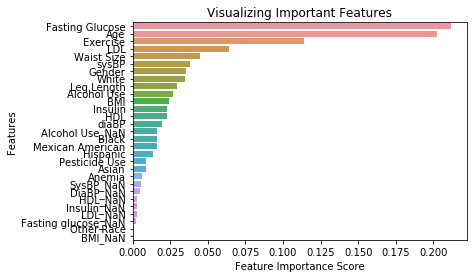

In [312]:
featimp = feature_importance(best_rf[1],X_names)

In [313]:
important_features = []
for feature, value in featimp.items():
    if value>0.01:
        important_features.append(feature)

# this time only use important features to rebuild rf see if it changes the result by much
dfxtrain = pd.DataFrame(X_train.values,columns = [X_names]) # original df X_train
dfxval = pd.DataFrame(X_val.values,columns = [X_names])     # original df X_val

X_train_imp = dfxtrain[important_features]
X_val_imp = dfxval[important_features]

dfxtrainval = pd.DataFrame(X_train_val.values,columns = [X_names])     # original df X_val
X_train_val_imp = dfxtrainval[important_features]

In [314]:
best_rf = hyperparameters(pipeline1,'random',rf_grid)
best_rf_final = no_cv(best_rf, X_train_imp, y_train, X_val_imp, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.96      0.97      2542
mentally ill       0.69      0.84      0.76       262

    accuracy                           0.95      2804
   macro avg       0.84      0.90      0.87      2804
weighted avg       0.96      0.95      0.95      2804

Val
              precision    recall  f1-score   support

     healthy       0.96      0.94      0.95       635
mentally ill       0.51      0.65      0.57        66

    accuracy                           0.91       701
   macro avg       0.74      0.79      0.76       701
weighted avg       0.92      0.91      0.91       701

Logloss: 3.15
roc auc: 0.7934741111906465


In [315]:
cv(best_rf, X_train_val_imp, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


accuracy
0.9024139858867652
[0.9031339  0.91168091 0.92022792 0.87749288 0.94871795 0.87179487
 0.90883191 0.89142857 0.88825215 0.9025788 ]
recall
0.6245265151515151
[0.63636364 0.63636364 0.63636364 0.75757576 0.72727273 0.60606061
 0.60606061 0.54545455 0.5        0.59375   ]
precision
0.4946595752466427
[0.48837209 0.525      0.56756757 0.41666667 0.72727273 0.38461538
 0.51282051 0.43902439 0.41025641 0.475     ]


In [316]:
rf = RandomForestClassifier(random_state = 42, criterion= 'gini')
pca = PCA(0.95)
pipeline2 = Pipeline([('sm', sm),('pca',pca),('rf', rf)])
best_rf = hyperparameters(pipeline2,'random',rf_grid)
cv(best_rf, X_train_val_imp, y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


accuracy
0.8847436515516744
[0.87464387 0.90598291 0.9002849  0.86894587 0.9031339  0.86609687
 0.86609687 0.87428571 0.8739255  0.91404011]
recall
0.6526515151515152
[0.6969697  0.54545455 0.60606061 0.81818182 0.72727273 0.6969697
 0.54545455 0.51515152 0.59375    0.78125   ]
precision
0.4294424685558958
[0.40350877 0.5        0.47619048 0.40298507 0.48979592 0.38333333
 0.36       0.37777778 0.38       0.52083333]


In [317]:
# random search on another grid2: with a wider range
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [10,20,30,40,50]
min_samples_leaf = [10,20,30,40,50] 
bootstrap = [True]

rf_grid =  {'rf__bootstrap': bootstrap,
            'rf__max_depth': max_depth,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leaf,
            'rf__min_samples_split': min_samples_split,
            'rf__n_estimators': n_estimators}

In [318]:
def generate_parameter_score(clf):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    y_val_pred = clf.predict(X_val)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)
    return roc_auc_train,roc_auc_val

def plot_parameter_score(parameters,scores,color):
    line = plt.plot(parameters,scores,color)
    for x,y in zip(parameters,scores):
        label = str(x)+', '+"{:.2f}".format(y)
        plt.annotate(label, (x,y),textcoords="offset points",xytext=(0,10),ha='center') 

def plot_parameter_scores(parameters,parameter_name,train_results,val_results):
    plt.figure(figsize=(20,10))
    plot_parameter_score(parameters,train_results,color='bo-')
    plot_parameter_score(parameters,val_results,color='ro-')
    plt.ylabel('AUC score')
    plt.xlabel(parameter_name)
    plt.legend(['train','val'])
    plt.show()

* See how roc auc scores changes as one parameter changes in a range

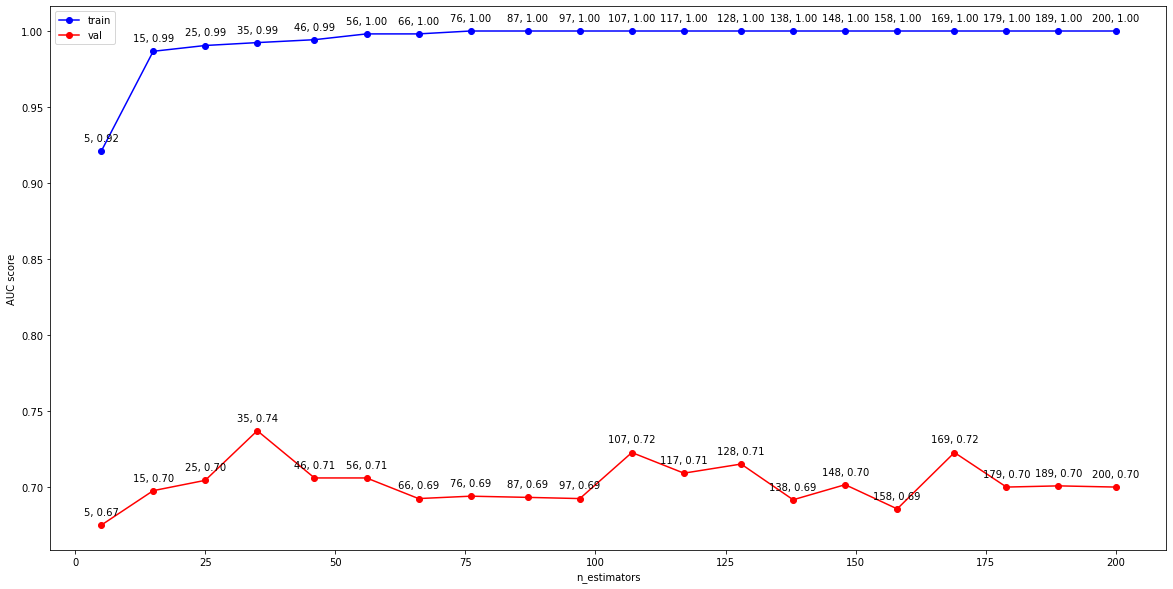

In [319]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 20)]
train_results = []
val_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(n_estimators,'n_estimators',train_results,val_results)

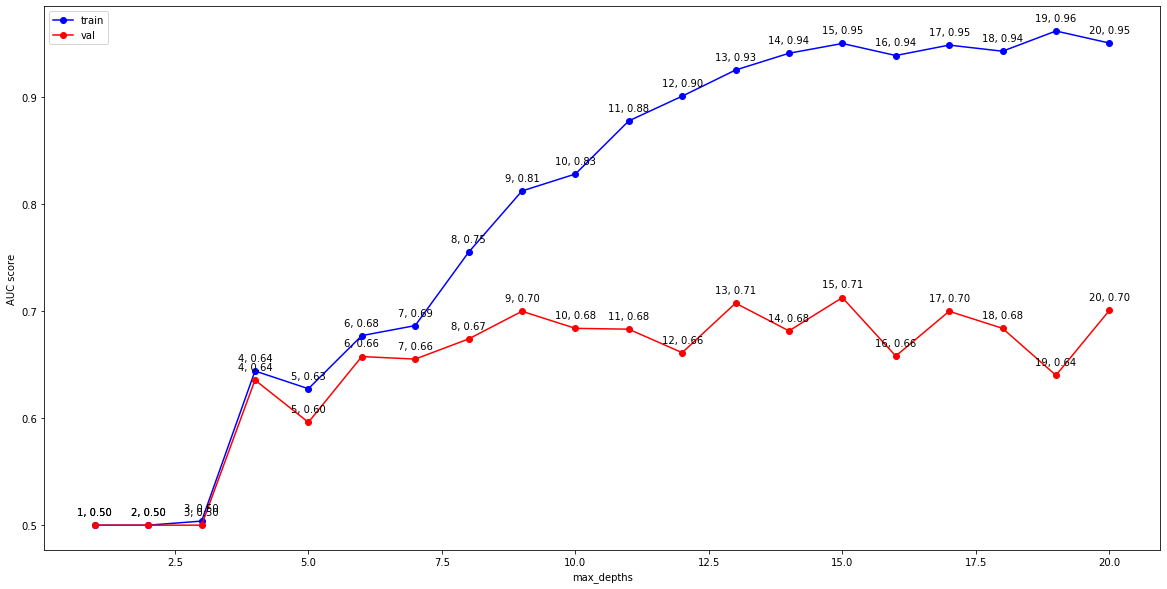

In [320]:
max_depths = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
train_results = []
val_results = []
for depth in max_depths:
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_depths,'max_depths',train_results,val_results)

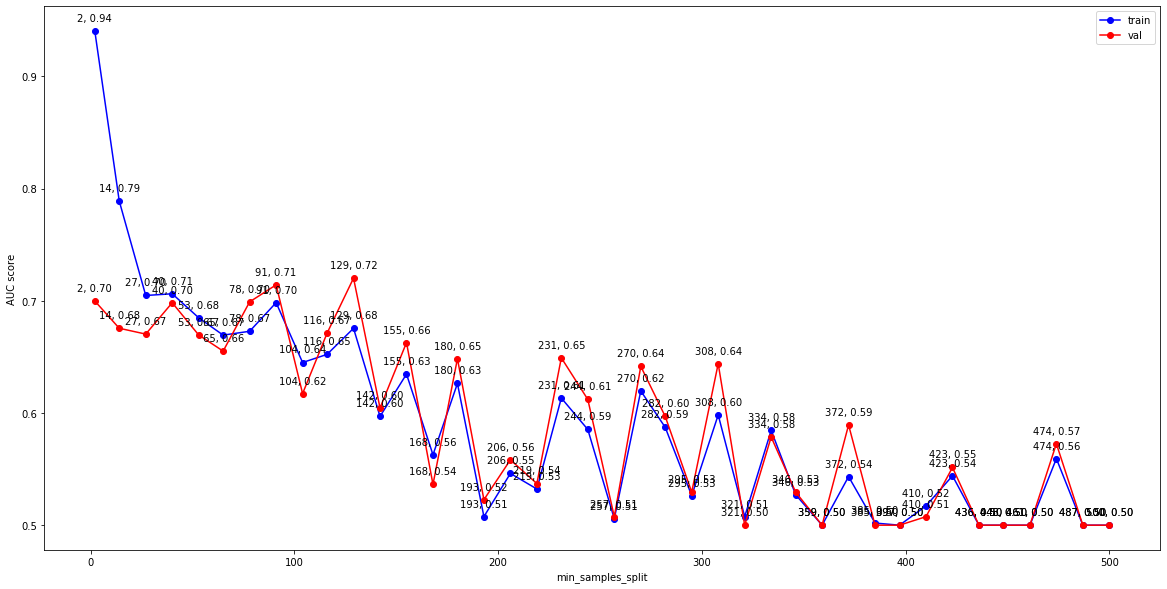

In [321]:
min_samples_splits = [int(x) for x in np.linspace(start = 2, stop = 500, num = 40)]
train_results = []
val_results = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_splits,'min_samples_split',train_results,val_results)

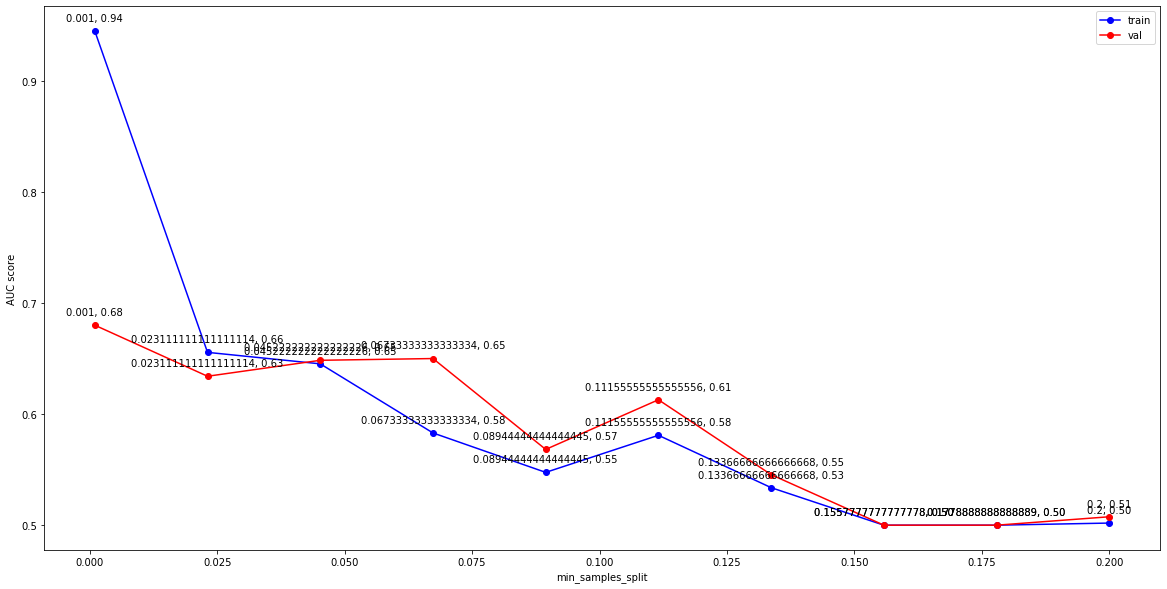

In [322]:
min_samples_splits = np.linspace(0.001, 0.2, 10, endpoint=True)
train_results = []
val_results = []
for split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=split, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_splits,'min_samples_split',train_results,val_results)

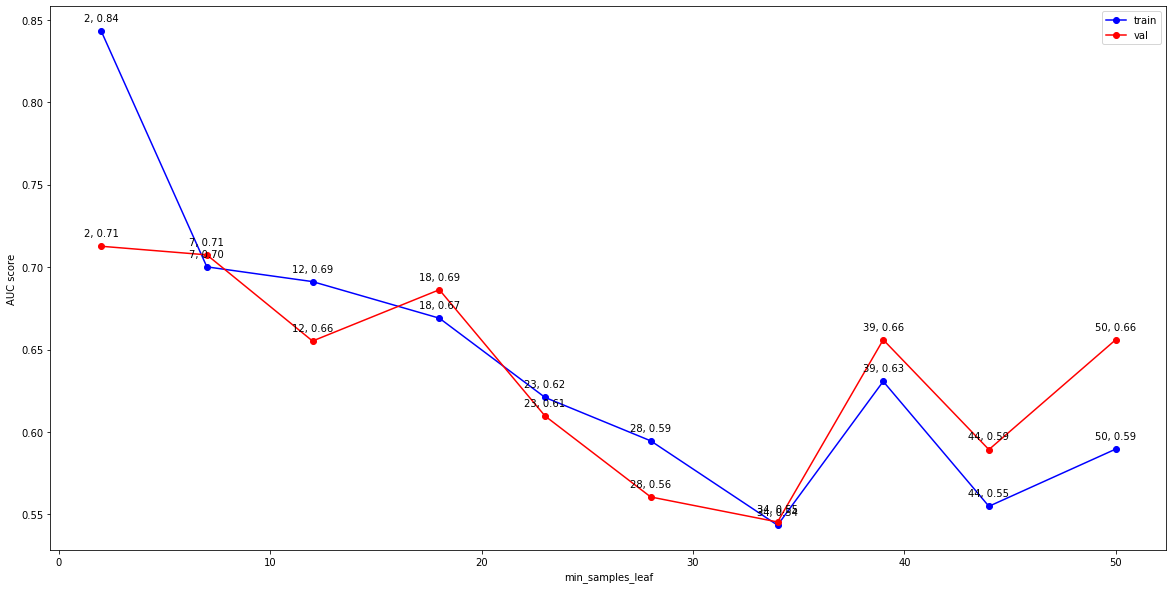

In [323]:
# min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
min_samples_leafs = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)] 
train_results = []
val_results = []
for leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=leaf, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_samples_leafs,'min_samples_leaf',train_results,val_results)

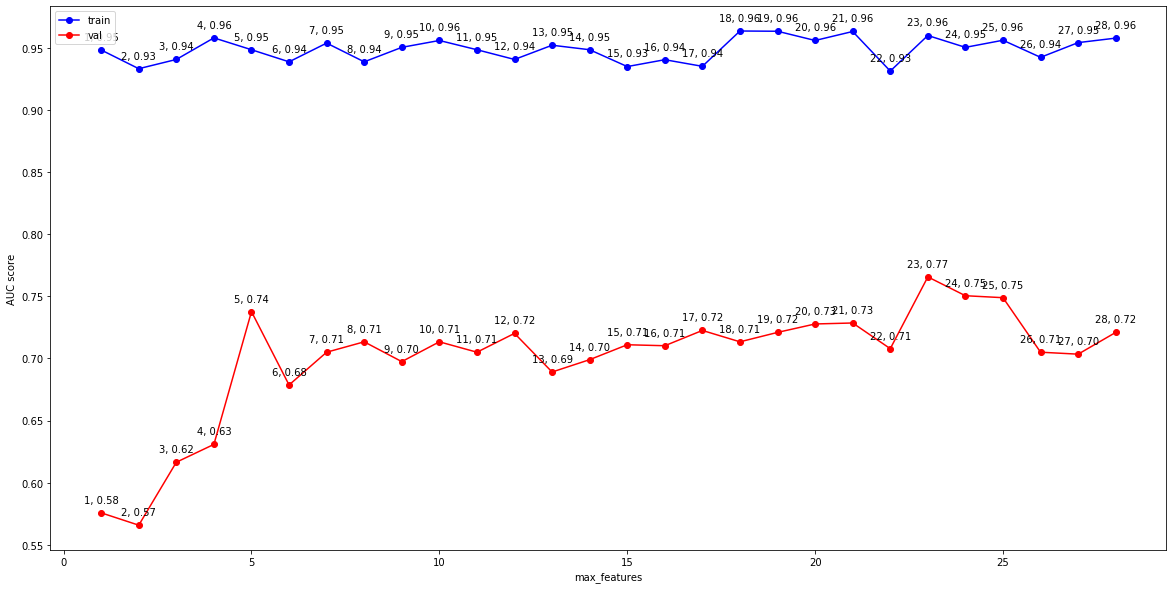

In [324]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
val_results = []
for feature in max_features:
    rf = RandomForestClassifier(max_features=feature, n_jobs=-1)
    roc_auc_train,roc_auc_val = generate_parameter_score(rf)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_features,'max_features',train_results,val_results)

In [325]:
# narrow down the parameter search range based on the plots generated
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)]
max_depths = [int(x) for x in np.linspace(start = 10, stop = 15, num = 5)]
min_samples_splits = np.linspace(0.075, 0.125, 5, endpoint=True)
min_samples_leafs = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)] 
max_features = list(range(10,X_train.shape[1]))

rf_grid2 = {'rf__max_depth': max_depths,
            'rf__max_features': max_features,
            'rf__min_samples_leaf': min_samples_leafs,
            'rf__min_samples_split': min_samples_splits,
            'rf__n_estimators': n_estimators}

rf = RandomForestClassifier(random_state = 42, criterion= 'gini')
pipeline8 = Pipeline([('sm', sm), ('rf', rf)])
best_rf = hyperparameters(pipeline8, 'random', rf_grid2)
cv(best_rf,X_train_val,y_train_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


accuracy
0.870168031692387
[0.86324786 0.88888889 0.87749288 0.85754986 0.91737892 0.84330484
 0.87749288 0.86285714 0.86532951 0.84813754]
recall
0.6980113636363636
[0.6969697  0.75757576 0.72727273 0.81818182 0.78787879 0.57575758
 0.66666667 0.60606061 0.59375    0.75      ]
precision
0.3953246302716923
[0.37704918 0.44642857 0.4137931  0.38028169 0.54166667 0.31666667
 0.40740741 0.36363636 0.35849057 0.34782609]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


In [326]:
fitted_rf = no_cv(best_rf,X_train, y_train, X_val, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished



Train
              precision    recall  f1-score   support

     healthy       0.97      0.88      0.92      2542
mentally ill       0.40      0.76      0.52       262

    accuracy                           0.87      2804
   macro avg       0.68      0.82      0.72      2804
weighted avg       0.92      0.87      0.89      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.90      0.94       635
mentally ill       0.48      0.85      0.61        66

    accuracy                           0.90       701
   macro avg       0.73      0.88      0.78       701
weighted avg       0.94      0.90      0.91       701

Logloss: 3.50
roc auc: 0.8762109281794322


In [327]:
best_rf_final.best_estimator_

Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('rf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=45,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=20,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None

In [328]:
# splitting into 20 diff train sizes
train_sizes = [int(x) for x in np.linspace(start = 100, stop = X_train.shape[0]-1, num = 30)]

# more training entries(row) will not change the results -> more features might
from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(best_rf_final.best_estimator_[1], cv=5, scoring='accuracy', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train_val, y_train_val)   
# plt.ylim(0, 1)

visualizer.show()   

ModuleNotFoundError: No module named 'yellowbrick'

## FEATURE SELECTION

In [329]:
pca = PCA(0.9)
principal_components = pca.fit_transform(X_train)
principal_df = pd.DataFrame(data = principal_components)
principal_df.shape

(2804, 13)

In [330]:
def selected_train_val(features):
    selected_X_train = X_train[features]
    selected_X_val = X_val[features]
    selected_X_train_val = X_train_val[features]
    return selected_X_train, selected_X_val, selected_X_train_val

relevant
Diabetes           1.000000
Fasting Glucose    0.447641
Age                0.272656
Exercise           0.175597
Waist Size         0.156855
Name: Diabetes, dtype: float64

irrelevant
['Anemia', 'BMI', 'HDL', 'LDL', 'Pesticide Use', 'Alcohol Use', 'Gender', 'Insulin', 'Leg Length', 'sysBP', 'diaBP', 'BMI_NaN', 'Fasting glucose_NaN', 'LDL_NaN', 'HDL_NaN', 'Insulin_NaN', 'SysBP_NaN', 'DiaBP_NaN', 'Alcohol Use_NaN', 'Mexican American', 'Hispanic', 'White', 'Black', 'Asian', 'Other Race']
['Fasting Glucose', 'Age', 'Exercise', 'Waist Size']


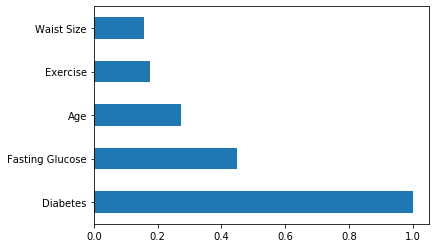

In [331]:
# pearson between numerical variables and y 
correlation_coefficient = 0.15
def feature_target_correlation(df,threshold):
    cor = df.corr()
    cor_target = abs(cor['Diabetes'])
    irrelevant_features = cor_target[cor_target<threshold]
    relevant_features = cor_target[cor_target>threshold].sort_values(ascending=False)
    relevant_features.plot(kind='barh')
    print('relevant')
    print(relevant_features)
    print()
    print('irrelevant')
    print(list(irrelevant_features.index))

    return list(relevant_features.index)[1:]

pearson_num = feature_target_correlation(df,correlation_coefficient)
print(pearson_num)

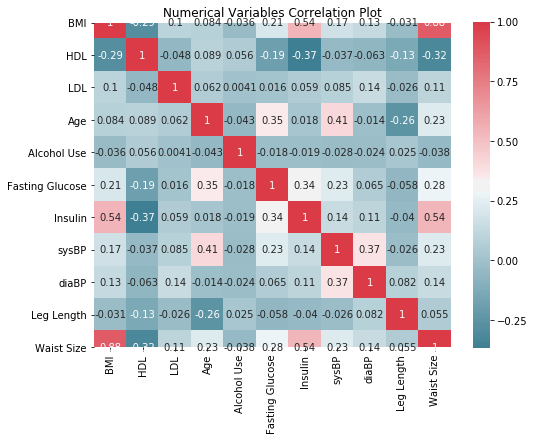

In [332]:
corr_df = df[numerical_variables]
cor = corr_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(8, 6))
plt.title("Numerical Variables Correlation Plot")
# sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
#             square=True, ax=ax, annot=True)
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

plt.show()

#### Attempt 2: selected features using Lasso + logreg
* A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. 

In [333]:
# logreg: default L2
logreg = LogisticRegression()
pipeline2 = Pipeline([('sm', sm), ('logreg', logreg)])
fitted_lr = no_cv(pipeline2, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.81      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.82      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.80      0.47        66

    accuracy                           0.83       701
   macro avg       0.65      0.82      0.68       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.96
roc auc: 0.8164757814364113


In [334]:
# lasso
logreg = LogisticRegression(penalty='l1',n_jobs =-1,solver='liblinear')
pipeline3 = Pipeline([('sm', sm), ('logreg', logreg)])
no_cv(pipeline3, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.81      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.82      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.80      0.47        66

    accuracy                           0.83       701
   macro avg       0.65      0.82      0.68       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.96
roc auc: 0.8164757814364113


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l1',
                                    random_state=None, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [335]:
grid = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
best_logreg = hyperparameters(pipeline3, 'gridsearch', grid)
fitted_lassolr = no_cv(best_logreg,X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90      2542
mentally ill       0.33      0.82      0.47       262

    accuracy                           0.83      2804
   macro avg       0.65      0.83      0.68      2804
weighted avg       0.92      0.83      0.86      2804

Val
              precision    recall  f1-score   support

     healthy       0.98      0.83      0.90       635
mentally ill       0.33      0.82      0.47        66

    accuracy                           0.83       701
   macro avg       0.66      0.82      0.69       701
weighted avg       0.92      0.83      0.86       701

Logloss: 5.91
roc auc: 0.824051539012169


In [336]:
cv(best_logreg,X_train_val,y_train_val)

accuracy
0.8228134037245786
[0.82051282 0.83190883 0.84045584 0.8034188  0.84900285 0.81481481
 0.82621083 0.80857143 0.81948424 0.81375358]
recall
0.7955492424242424
[0.84848485 0.87878788 0.78787879 0.87878788 0.75757576 0.78787879
 0.75757576 0.72727273 0.75       0.78125   ]
precision
0.3214691866548811
[0.32941176 0.3452381  0.34666667 0.30851064 0.35714286 0.30952381
 0.32051282 0.29268293 0.30379747 0.30120482]


In [337]:
pipeline4 = Pipeline([('sm', sm), ('pca',pca),('logreg', logreg)])
best_logreg = hyperparameters(pipeline3, 'gridsearch', grid)
cv(best_logreg,X_train_val,y_train_val)

accuracy
0.8230983040094788
[0.82336182 0.83190883 0.84045584 0.8034188  0.84900285 0.81481481
 0.82621083 0.80857143 0.81948424 0.81375358]
recall
0.7955492424242424
[0.84848485 0.87878788 0.78787879 0.87878788 0.75757576 0.78787879
 0.75757576 0.72727273 0.75       0.78125   ]
precision
0.32186812282509386
[0.32941176 0.3452381  0.34666667 0.3125     0.35714286 0.30952381
 0.32051282 0.29268293 0.30379747 0.30120482]


#### Attempt 3: knn



In [338]:
knn = KNeighborsClassifier()
pipeline5 = Pipeline([('sm', sm),('knn', knn)])
no_cv(pipeline5, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      0.86      0.93      2542
mentally ill       0.43      1.00      0.60       262

    accuracy                           0.87      2804
   macro avg       0.71      0.93      0.76      2804
weighted avg       0.95      0.87      0.90      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.83      0.89       635
mentally ill       0.30      0.71      0.42        66

    accuracy                           0.82       701
   macro avg       0.63      0.77      0.66       701
weighted avg       0.90      0.82      0.85       701

Logloss: 6.31
roc auc: 0.7702338344070627


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

* small k: low bias, high variance; large k: high bias, low variance

In [339]:
knn_grid =  {'knn__metric': ['euclidean','manhattan'],
             'knn__weights': ['uniform','distance'],
             'knn__n_neighbors': [3,4,5,7,10,15,20]}
best_knn = hyperparameters(pipeline5,'gridsearch',knn_grid)

In [340]:
no_cv(best_knn, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      2542
mentally ill       1.00      1.00      1.00       262

    accuracy                           1.00      2804
   macro avg       1.00      1.00      1.00      2804
weighted avg       1.00      1.00      1.00      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.84      0.90       635
mentally ill       0.33      0.76      0.46        66

    accuracy                           0.83       701
   macro avg       0.65      0.80      0.68       701
weighted avg       0.91      0.83      0.86       701

Logloss: 5.72
roc auc: 0.8000477213075639


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                   

In [341]:
pipeline6 = Pipeline([('sm', sm),('pca',pca),('knn', knn)])
best_knn = hyperparameters(pipeline6,'gridsearch',knn_grid)
fitted_knn = no_cv(best_knn, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       1.00      0.92      0.96      2542
mentally ill       0.57      1.00      0.73       262

    accuracy                           0.93      2804
   macro avg       0.79      0.96      0.84      2804
weighted avg       0.96      0.93      0.94      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.86      0.90       635
mentally ill       0.31      0.61      0.41        66

    accuracy                           0.83       701
   macro avg       0.63      0.73      0.66       701
weighted avg       0.89      0.83      0.86       701

Logloss: 5.72
roc auc: 0.7321641612980195


In [343]:
cv(best_knn, X_train_val, y_train_val)

accuracy
0.8341947117935656
[0.85754986 0.86609687 0.82336182 0.84330484 0.84330484 0.86324786
 0.82336182 0.82       0.7765043  0.8252149 ]
recall
0.640625
[0.54545455 0.60606061 0.63636364 0.87878788 0.66666667 0.6969697
 0.42424242 0.54545455 0.75       0.65625   ]
precision
0.31480852780668167
[0.33962264 0.37037037 0.29577465 0.3625     0.33333333 0.37704918
 0.24561404 0.27272727 0.25531915 0.29577465]


#### Attempt 4: XGBoost


In [344]:
xgb1 = XGBClassifier()
pipeline7 = Pipeline([('sm', sm),('xgb1', xgb1)])
no_cv(pipeline7, X_train.values, y_train.values, X_val.values, y_val.values)



Train
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00      2542
mentally ill       1.00      1.00      1.00       262

    accuracy                           1.00      2804
   macro avg       1.00      1.00      1.00      2804
weighted avg       1.00      1.00      1.00      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.97      0.96       635
mentally ill       0.69      0.53      0.60        66

    accuracy                           0.93       701
   macro avg       0.82      0.75      0.78       701
weighted avg       0.93      0.93      0.93       701

Logloss: 2.32
roc auc: 0.7525530899546647


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('xgb1',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type...
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logis

In [345]:
xgb_grid =  {'xgb1__min_child_weight': [1, 5, 10],
             'xgb1__gamma': [0.5, 1, 1.5, 2, 5],
             'xgb1__subsample': [0.6, 0.8, 1.0],
             'xgb1__colsample_bytree': [0.6, 0.8, 1.0],
             'xgb1__max_depth': [3, 4, 5]}
best_xgb1 = hyperparameters(pipeline7,'random',xgb_grid)

In [346]:
best_xgb1 = no_cv(best_xgb1, X_train.values, y_train.values, X_val.values, y_val.values)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.5s finished



Train
              precision    recall  f1-score   support

     healthy       0.98      0.99      0.99      2542
mentally ill       0.93      0.81      0.87       262

    accuracy                           0.98      2804
   macro avg       0.96      0.90      0.93      2804
weighted avg       0.98      0.98      0.98      2804

Val
              precision    recall  f1-score   support

     healthy       0.95      0.96      0.96       635
mentally ill       0.58      0.55      0.56        66

    accuracy                           0.92       701
   macro avg       0.77      0.75      0.76       701
weighted avg       0.92      0.92      0.92       701

Logloss: 2.76
roc auc: 0.7522548317823908


In [347]:
best_xgb = best_xgb1.best_estimator_[1]

feature importance
Exercise               0.146211
Fasting Glucose        0.119399
Age                    0.090549
Gender                 0.074498
Hispanic               0.065999
Anemia                 0.056865
Mexican American       0.053876
Alcohol Use_NaN        0.052573
Pesticide Use          0.048003
White                  0.046983
Alcohol Use            0.034613
Black                  0.027962
Asian                  0.024740
LDL                    0.023323
HDL                    0.017854
LDL_NaN                0.016035
SysBP_NaN              0.015891
Insulin_NaN            0.014038
Other Race             0.011307
diaBP                  0.010576
Waist Size             0.010303
sysBP                  0.007783
Leg Length             0.007638
DiaBP_NaN              0.007526
Insulin                0.006803
BMI                    0.006679
BMI_NaN                0.001972
Fasting glucose_NaN    0.000000
HDL_NaN                0.000000
dtype: float32


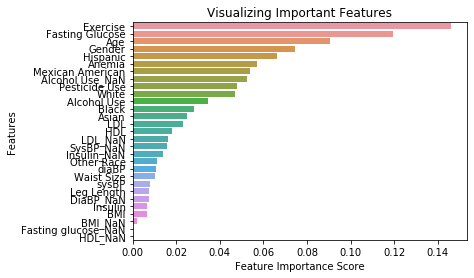

Exercise               0.146211
Fasting Glucose        0.119399
Age                    0.090549
Gender                 0.074498
Hispanic               0.065999
Anemia                 0.056865
Mexican American       0.053876
Alcohol Use_NaN        0.052573
Pesticide Use          0.048003
White                  0.046983
Alcohol Use            0.034613
Black                  0.027962
Asian                  0.024740
LDL                    0.023323
HDL                    0.017854
LDL_NaN                0.016035
SysBP_NaN              0.015891
Insulin_NaN            0.014038
Other Race             0.011307
diaBP                  0.010576
Waist Size             0.010303
sysBP                  0.007783
Leg Length             0.007638
DiaBP_NaN              0.007526
Insulin                0.006803
BMI                    0.006679
BMI_NaN                0.001972
Fasting glucose_NaN    0.000000
HDL_NaN                0.000000
dtype: float32

In [348]:
feature_importance(best_xgb,X_names)

In [349]:
cv(best_xgb1, X_train_val.as_matrix(), y_train_val.as_matrix())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.8s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.9s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


accuracy
0.9258051785845482
[0.92592593 0.93447293 0.92592593 0.93447293 0.94301994 0.92307692
 0.92592593 0.91428571 0.89971347 0.93123209]
recall
0.5209280303030303
[0.51515152 0.51515152 0.57575758 0.66666667 0.54545455 0.54545455
 0.51515152 0.42424242 0.4375     0.46875   ]
precision
0.6303594422624619
[0.62962963 0.70833333 0.61290323 0.64705882 0.7826087  0.6
 0.62962963 0.56       0.4516129  0.68181818]


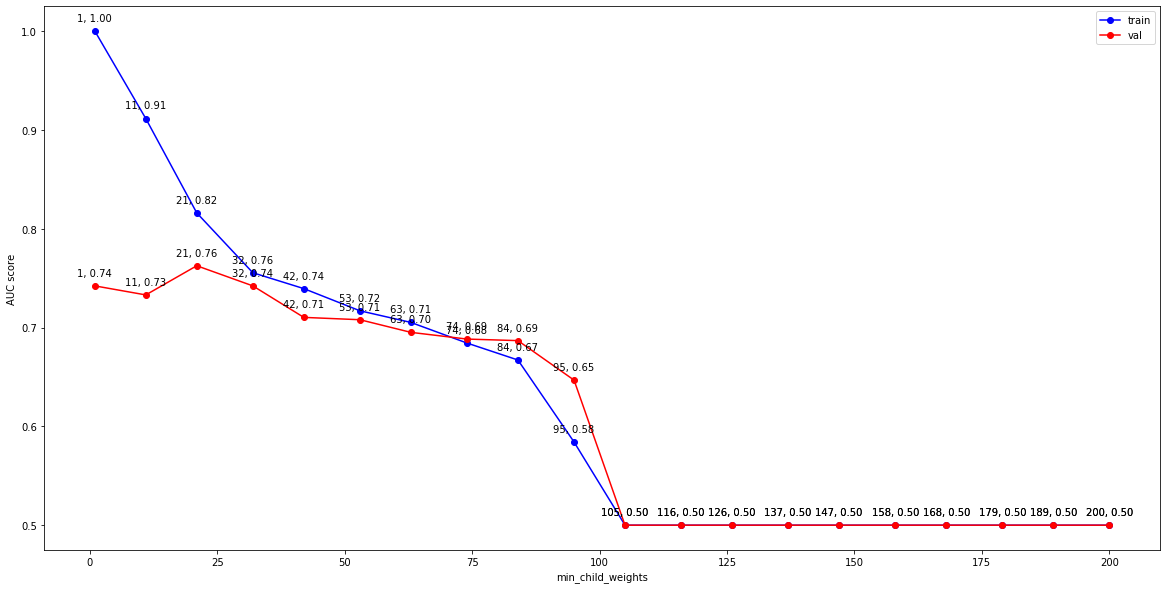

In [350]:
min_child_weights = [int(x) for x in np.linspace(start = 1, stop = 200, num = 20)] 
train_results = []
val_results = []
for weight in min_child_weights:
    xgb = XGBClassifier(min_child_weight=weight)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(min_child_weights,'min_child_weights',train_results,val_results)

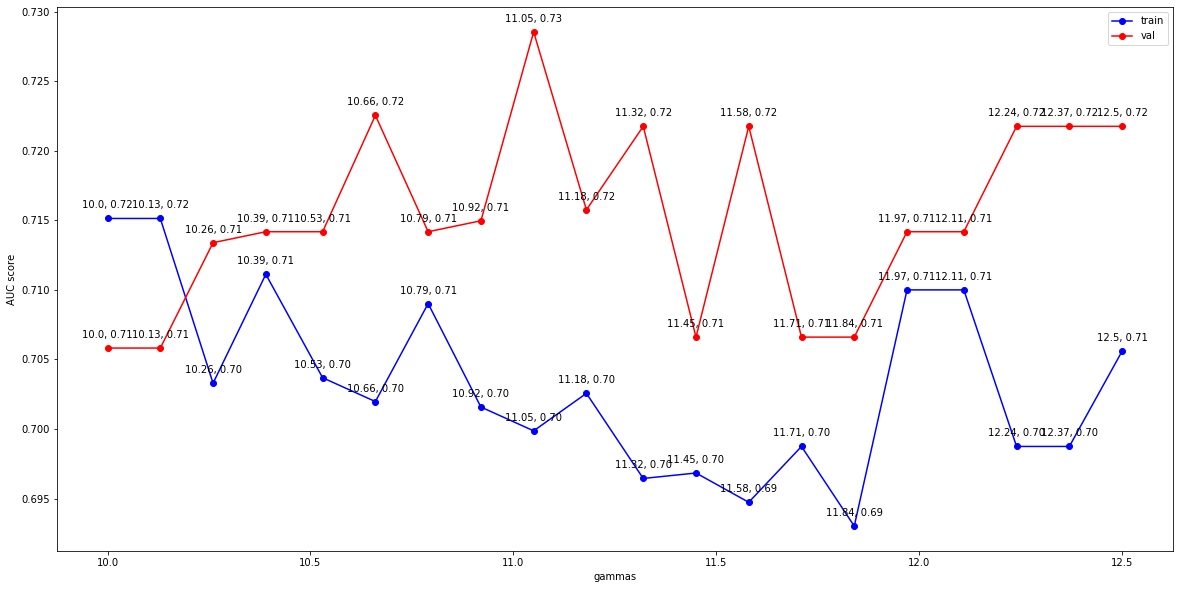

In [351]:
gammas = [round(x,2) for x in np.linspace(start = 10, stop = 12.5, num = 20)] 
train_results = []
val_results = []
for gamma in gammas:
    xgb = XGBClassifier(gamma=gamma)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(gammas,'gammas',train_results,val_results)

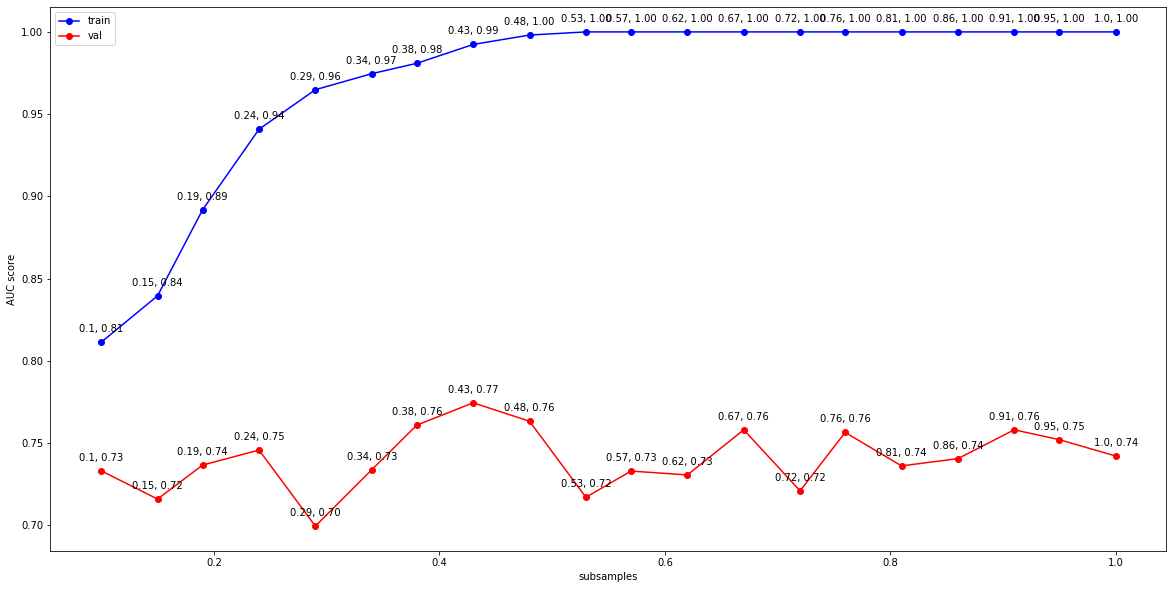

In [352]:
subsamples = [round(x,2) for x in np.linspace(start = 0.1, stop = 1, num = 20)] 
train_results = []
val_results = []
for subsample in subsamples:
    xgb = XGBClassifier(subsample=subsample)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(subsamples,'subsamples',train_results,val_results)

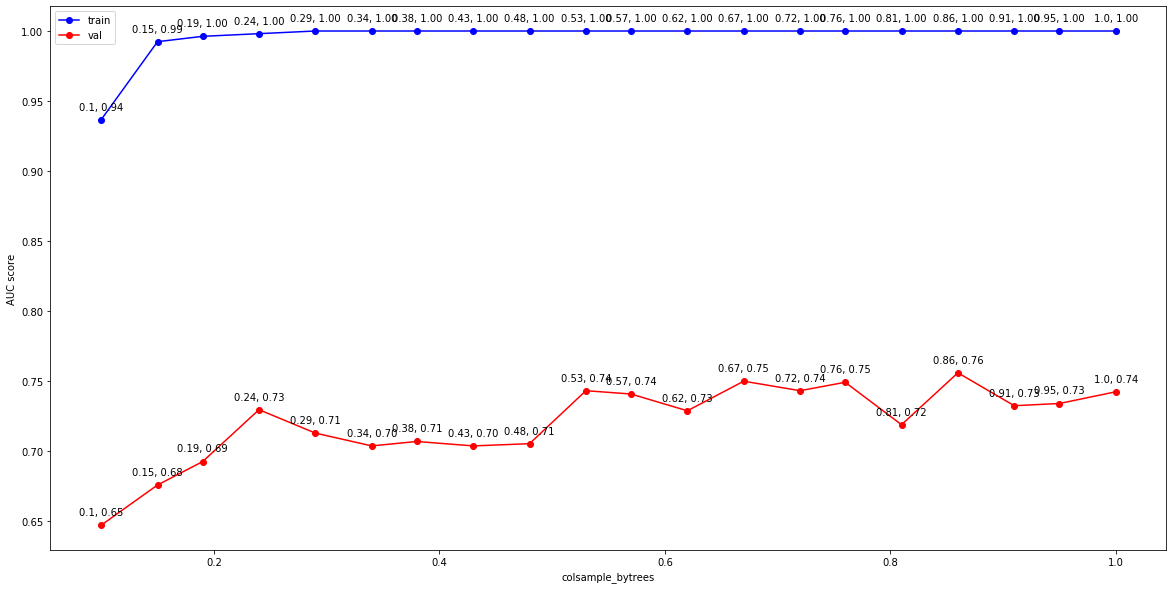

In [353]:
colsample_bytrees = [round(x,2) for x in np.linspace(start = 0.1, stop = 1, num = 20)] 
train_results = []
val_results = []
for colsample_bytree in colsample_bytrees:
    xgb = XGBClassifier(colsample_bytree=colsample_bytree)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(colsample_bytrees,'colsample_bytrees',train_results,val_results)

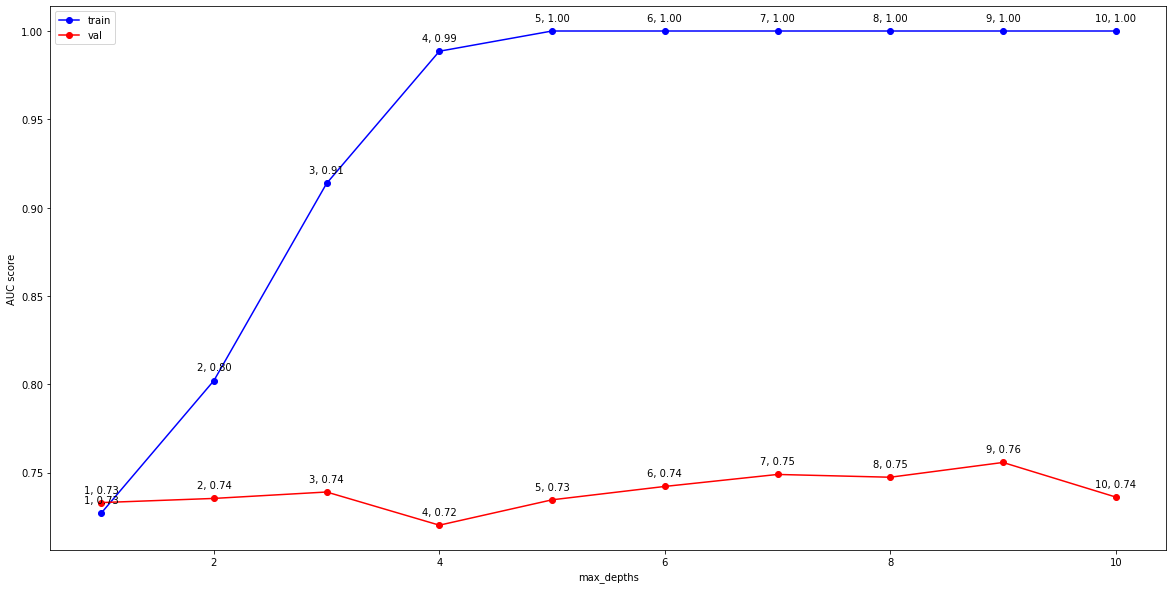

In [354]:
max_depths = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)] 
train_results = []
val_results = []
for max_depth in max_depths:
    xgb = XGBClassifier(max_depth=max_depth)
    roc_auc_train,roc_auc_val = generate_parameter_score(xgb)
    train_results.append(roc_auc_train)
    val_results.append(roc_auc_val)

plot_parameter_scores(max_depths,'max_depths',train_results,val_results)

In [355]:
xgb_grid2 = {'xgb1__min_child_weight': [i for i in range(0,25)],
             'xgb1__gamma': [round(x,2) for x in np.linspace(start = 10, stop = 10.5, num = 5)],
             'xgb1__subsample': [0.2,0.3,0.4],
             'xgb1__colsample_bytree': [0.2,0.3,0.4,0.5,0.6],
             'xgb1__max_depth': [1,2,3, 4, 5]}
best_xgb2 = hyperparameters(pipeline7,'random',xgb_grid2)

In [356]:
cv(best_xgb2, X_train_val.values, y_train_val.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.7s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.3s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


accuracy
0.9095446610059791
[0.92307692 0.91737892 0.91737892 0.90883191 0.92307692 0.89173789
 0.92022792 0.88571429 0.89111748 0.91690544]
recall
0.5178977272727273
[0.57575758 0.57575758 0.45454545 0.75757576 0.57575758 0.45454545
 0.45454545 0.42424242 0.40625    0.5       ]
precision
0.5219996254469957
[0.59375    0.55882353 0.57692308 0.51020408 0.59375    0.42857143
 0.6        0.4        0.40625    0.55172414]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


In [357]:
best_xgb = best_xgb1.best_estimator_[1]

In [358]:
train_sizes = [int(x) for x in np.linspace(start = 100, stop = 2242, num = 30)]
visualizer = LearningCurve(best_xgb, cv=5, scoring='accuracy', train_sizes=train_sizes, n_jobs=4)
visualizer.fit(X_train, y_train)        
visualizer.show()   

NameError: name 'LearningCurve' is not defined

#### Attempt 5: SVM

In [359]:
svc = SVC(probability=True)
pipeline8 = Pipeline([('sm', sm),('svc', svc)])
no_cv(pipeline8, X_train, y_train, X_val, y_val)


Train
              precision    recall  f1-score   support

     healthy       0.99      0.88      0.93      2542
mentally ill       0.44      0.91      0.60       262

    accuracy                           0.88      2804
   macro avg       0.72      0.90      0.76      2804
weighted avg       0.94      0.88      0.90      2804

Val
              precision    recall  f1-score   support

     healthy       0.97      0.86      0.91       635
mentally ill       0.36      0.74      0.49        66

    accuracy                           0.85       701
   macro avg       0.67      0.80      0.70       701
weighted avg       0.91      0.85      0.87       701

Logloss: 5.12
roc auc: 0.8027081842042472


Pipeline(memory=None,
         steps=[('sm',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [360]:
Cs = [0.001, 0.01, 0.1, 1, 10,100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear', 'rbf', 'poly']
svc_grid =  {'svc__C': Cs,
             'svc__gamma': gammas,
             'svc__kernel': kernels}
best_svc = hyperparameters(pipeline8,'random',svc_grid)

In [361]:
fitted_svm = no_cv(best_svc, X_train, y_train, X_val, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   34.2s finished



Train
              precision    recall  f1-score   support

     healthy       0.91      1.00      0.95      2542
mentally ill       1.00      0.03      0.07       262

    accuracy                           0.91      2804
   macro avg       0.95      0.52      0.51      2804
weighted avg       0.92      0.91      0.87      2804

Val
              precision    recall  f1-score   support

     healthy       0.91      1.00      0.95       635
mentally ill       0.00      0.00      0.00        66

    accuracy                           0.91       701
   macro avg       0.45      0.50      0.48       701
weighted avg       0.82      0.91      0.86       701

Logloss: 3.25
roc auc: 0.5


## Ensemble method

#Chosen models :
fitted_rf = Model fitted based on narrow range of hyperparameters as chosen from the plots)
fitted_lr = Default Model 
fitted_lassolr (not used)
fitten_knn : Model fitted after hyperparamter tuning
best_xgb1 : Model fitted after hyperparamter tuning
fitted_svm : Model fitted after hyperparamter tuning

In [362]:
#Probabilities, predicitons and auc scores of models on the training set and Val sets

#Training set
rf_train_prob = fitted_rf.predict_proba(X_train)
rf_train_pred = fitted_rf.predict(X_train)

knn_train_prob = fitted_knn.predict_proba(X_train)
knn_train_pred = fitted_knn.predict(X_train)

svm_train_prob = fitted_svm.predict_proba(X_train)
svm_train_pred = fitted_svm.predict(X_train)

lr_train_prob = fitted_lr.predict_proba(X_train)
lr_train_pred = fitted_lr.predict(X_train)

xgb_train_prob = best_xgb1.predict_proba(X_train.values)
xgb_train_pred = best_xgb1.predict(X_train.values)

#Validation set
rf_val_prob = best_rf_final.predict_proba(X_val_imp)
rf_val_pred = best_rf_final.predict(X_val_imp)

knn_val_prob = fitted_knn.predict_proba(X_val)
knn_val_pred = fitted_knn.predict(X_val)

svm_val_prob = fitted_svm.predict_proba(X_val)
svm_val_pred = fitted_svm.predict(X_val)

lr_val_prob = fitted_lr.predict_proba(X_val)
lr_val_pred = fitted_lr.predict(X_val)

xgb_val_prob = best_xgb1.predict_proba(X_val.values)
xgb_val_pred = best_xgb1.predict(X_val.values)

#Test set

rf_test_prob = fitted_rf.predict_proba(X_test)
rf_test_pred = fitted_rf.predict(X_test)

knn_test_prob = fitted_knn.predict_proba(X_test)
knn_test_pred = fitted_knn.predict(X_test)

svm_test_prob = fitted_svm.predict_proba(X_test)
svm_test_pred = fitted_svm.predict(X_test)

lr_test_prob = fitted_lr.predict_proba(X_test)
lr_test_pred = fitted_lr.predict(X_test)

xgb_test_prob = best_xgb1.predict_proba(X_test.values)
xgb_test_pred = best_xgb1.predict(X_test.values)


#AUC Scores
rf_roc_auc = roc_auc_score(y_train, rf_train_pred)
knn_roc_auc = roc_auc_score(y_train, knn_train_pred)
svm_roc_auc = roc_auc_score(y_train, svm_train_pred)
lr_roc_auc = roc_auc_score(y_train, lr_train_pred)
xgb_roc_auc = roc_auc_score(y_train, xgb_train_pred)

In [363]:
#Dataframes for probabilities of someone being diabetic for Train, Val and Test sets from all the different models

df_train_prob = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb"], index= X_train.index)
for i in range(len(X_train)):
    df_train_prob["rf"].iloc[i] = rf_train_prob[i][1]
    df_train_prob["knn"].iloc[i] = knn_train_prob[i][1]
    df_train_prob["svm"].iloc[i] = svm_train_prob[i][1]
    df_train_prob["lr"].iloc[i] = lr_train_prob[i][1]
    df_train_prob["xgb"].iloc[i] = xgb_train_prob[i][1]
print("Train Probabilities")
print(df_train_prob)

df_val_prob = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb"], index= X_val.index)
for i in range(len(X_val)):
    df_val_prob["rf"].iloc[i] = rf_val_prob[i][1]
    df_val_prob["knn"].iloc[i] = knn_val_prob[i][1]
    df_val_prob["svm"].iloc[i] = svm_val_prob[i][1]
    df_val_prob["lr"].iloc[i] = lr_val_prob[i][1]
    df_val_prob["xgb"].iloc[i] = xgb_val_prob[i][1]
print("Val Probabilities")
print(df_val_prob)


df_test_prob = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb"], index= X_test.index)
for i in range(len(X_test)):
    df_test_prob["rf"].iloc[i] = rf_test_prob[i][1]
    df_test_prob["knn"].iloc[i] = knn_test_prob[i][1]
    df_test_prob["svm"].iloc[i] = svm_test_prob[i][1]
    df_test_prob["lr"].iloc[i] = lr_test_prob[i][1]
    df_test_prob["xgb"].iloc[i] = xgb_test_prob[i][1]
print("Test Probabilities")
print(df_test_prob)


#Dataframes for predictions of someone being diabetic for Train and Val sets from all different models
df_train_pred = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb", "True"], index= X_train.index)
for i in range(len(X_train)):
    df_train_pred["rf"].iloc[i] = rf_train_pred[i]
    df_train_pred["knn"].iloc[i] = knn_train_pred[i]
    df_train_pred["svm"].iloc[i] = svm_train_pred[i]
    df_train_pred["lr"].iloc[i] = lr_train_pred[i]
    df_train_pred["xgb"].iloc[i] = xgb_train_pred[i]
    df_train_pred["True"].iloc[i] = y_train.iloc[i]
print("Train Predictions")
print(df_train_pred)

df_val_pred = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb", "True"], index= X_val.index)
for i in range(len(X_val)):
    df_val_pred["rf"].iloc[i] = rf_val_pred[i]
    df_val_pred["knn"].iloc[i] = knn_val_pred[i]
    df_val_pred["svm"].iloc[i] = svm_val_pred[i]
    df_val_pred["lr"].iloc[i] = lr_val_pred[i]
    df_val_pred["xgb"].iloc[i] = xgb_val_pred[i]
    df_val_pred["True"].iloc[i] = y_val.iloc[i]
print("Val Predictions")
print(df_val_pred)



df_test_pred = pd.DataFrame(columns = ["rf", "knn", "svm", "lr", "xgb", "True"], index= X_test.index)
for i in range(len(X_test)):
    df_test_pred["rf"].iloc[i] = rf_test_pred[i]
    df_test_pred["knn"].iloc[i] = knn_test_pred[i]
    df_test_pred["svm"].iloc[i] = svm_test_pred[i]
    df_test_pred["lr"].iloc[i] = lr_test_pred[i]
    df_test_pred["xgb"].iloc[i] = xgb_test_pred[i]
    df_test_pred["True"].iloc[i] = y_test.iloc[i]

print("Test Predictions")
print(df_test_pred)


Train Probabilities
             rf   knn  svm         lr         xgb
2529   0.792392   0.5  0.5    0.94534    0.632068
3612   0.933196     1  0.5   0.985025    0.994534
2988   0.275595     0  0.5   0.205613   0.0127334
4004   0.202502     0  0.5  0.0542385   0.0134264
1925    0.23849     0  0.5   0.123269   0.0266699
...         ...   ...  ...        ...         ...
3099   0.218007   0.5  0.5   0.393814   0.0542817
2217  0.0620874     0  0.5  0.0448434  0.00949232
2485   0.260028     0  0.5   0.128609  0.00851677
2768   0.241196     0  0.5   0.159952  0.00601541
320   0.0287003  0.25  0.5  0.0632205  0.00474966

[2804 rows x 5 columns]
Val Probabilities
               rf   knn  svm         lr          xgb
2585    0.0674692     0  0.5  0.0645928    0.0023625
3446     0.105399     0  0.5   0.180544    0.0229532
1520     0.173755     0  0.5   0.502461    0.0251537
1826     0.120465     0  0.5   0.128832    0.0207259
944       0.19393     0  0.5   0.333733   0.00992832
...           ...  

### Simple average

Averages predicted probabilities of individual models to obtain the final probability.
A threshold of p = 0.5 was used to determine if a person is diabetic or not


https://arxiv.org/pdf/1708.07480.pdf

In [364]:
#Ensemble model and predictions on the training set
ensemble_train_prob1 = (rf_train_prob + knn_train_prob + svm_train_prob + lr_train_prob + xgb_train_prob)/5

ensemble_train_pred1 = []
for i in ensemble_train_prob1:
    if i[1] > 0.5:          #i[0] = Prob(Not diabetic) ; i[1] = Prob(Diabetic)
        value = 1
    else:
        value = 0
    ensemble_train_pred1.append(value)

print('Train')
print(classification_report(y_train_ensemble, ensemble_train_pred1))
print("Accuracy", accuracy_score(y_train_ensemble, ensemble_train_pred1))
print("ROC AUC",roc_auc_score(y_train_ensemble, ensemble_train_pred1))


#Ensemble model and predictions on the Validation set
ensemble_val_prob1 = (rf_val_prob + knn_val_prob + svm_val_prob + lr_val_prob + xgb_val_prob)/5

ensemble_val_pred1 = []
for i in ensemble_val_prob1:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_val_pred1.append(value)


print('Val')
print(classification_report(y_val, ensemble_val_pred1))
print("Accuracy", accuracy_score(y_val_ensemble, ensemble_val_pred1))
print("ROC AUC",roc_auc_score(y_val, ensemble_val_pred1))
print('Logloss: %.2f' % log_loss(y_val, ensemble_val_pred1))


Train
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2542
           1       0.62      0.94      0.74       262

    accuracy                           0.94      2804
   macro avg       0.80      0.94      0.85      2804
weighted avg       0.96      0.94      0.94      2804

Accuracy 0.9393723252496433
ROC AUC 0.9374628380610326
Val
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       635
         1.0       0.46      0.67      0.55        66

    accuracy                           0.90       701
   macro avg       0.71      0.79      0.74       701
weighted avg       0.92      0.90      0.90       701

Accuracy 0.8958630527817404
ROC AUC 0.7931758530183727
Logloss: 3.60


### AUC weighted 

Probabilities are a weighted average of AUC scores. A threshold of p = 0.5 was used to determine if a person is diabetic or not


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6836338/pdf/12911_2019_Article_918.pdf

In [365]:
#AUC weights
rf_weight = rf_roc_auc / (rf_roc_auc + knn_roc_auc + svm_roc_auc + lr_roc_auc + xgb_roc_auc)
knn_weight = knn_roc_auc / (rf_roc_auc + knn_roc_auc + svm_roc_auc + lr_roc_auc + xgb_roc_auc)
svm_weight = svm_roc_auc / (rf_roc_auc + knn_roc_auc + svm_roc_auc + lr_roc_auc + xgb_roc_auc)
lr_weight = lr_roc_auc / (rf_roc_auc + knn_roc_auc + svm_roc_auc + lr_roc_auc + xgb_roc_auc)
xgb_weight = xgb_roc_auc / (rf_roc_auc + knn_roc_auc + svm_roc_auc + lr_roc_auc + xgb_roc_auc)

#Ensemble model and predictions on the training set
ensemble_train_prob2 = (rf_weight*rf_train_prob) + (knn_train_prob*knn_weight) + (svm_train_prob*svm_weight) + (lr_train_prob*lr_weight) + (xgb_train_prob*xgb_weight)

ensemble_train_pred2 = []
for i in ensemble_train_prob2:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_train_pred2.append(value)

print('Train')
print(classification_report(y_train_ensemble, ensemble_train_pred2))
print("Accuracy", accuracy_score(y_train_ensemble, ensemble_train_pred2))
print("ROC AUC",roc_auc_score(y_train_ensemble, ensemble_train_pred2))


#Ensemble model and predictions on the Validation set
ensemble_val_prob2 = (rf_weight*rf_val_prob) + (knn_val_prob*knn_weight) + (svm_val_prob*svm_weight) + (lr_val_prob*lr_weight) + (xgb_val_prob*xgb_weight)
#print("Final probabilites of each subject using the ensemble model is", ensemble_val_prob)

ensemble_val_pred2 = []
for i in ensemble_val_prob2:
    if i[1] > 0.5:
        value = 1
    else:
        value = 0
    ensemble_val_pred2.append(value)


print('Val')
print(classification_report(y_val, ensemble_val_pred2))
print("Accuracy", accuracy_score(y_val_ensemble, ensemble_val_pred2))
print("ROC AUC",roc_auc_score(y_val, ensemble_val_pred2))
print('Logloss: %.2f' % log_loss(y_val, ensemble_val_pred2))


Train
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2542
           1       0.63      0.94      0.75       262

    accuracy                           0.94      2804
   macro avg       0.81      0.94      0.86      2804
weighted avg       0.96      0.94      0.95      2804

Accuracy 0.9429386590584878
ROC AUC 0.9411414946456778
Val
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       635
         1.0       0.46      0.65      0.54        66

    accuracy                           0.90       701
   macro avg       0.71      0.79      0.74       701
weighted avg       0.92      0.90      0.90       701

Accuracy 0.8958630527817404
ROC AUC 0.7863874970174183
Logloss: 3.60


### Majority voting

Since 5 models are chosen to build the ensemble model, if more than 3 out of 5 models predict that a subject is diabetic, then the final ensemble model also predicts that the subject is diabetic

https://www.ijrte.org/wp-content/uploads/papers/v7i6s4/F10390476S419.pdf

In [366]:
#Training set
sum_train_pred = rf_train_pred + svm_train_pred + knn_train_pred + lr_train_pred + xgb_train_pred
#print(sum_train_pred)

ensemble_train_pred3 = []

for i in range(len(X_train)):
    if sum_train_pred[i] > 2:
        value = 1
    else:
        value = 0
    ensemble_train_pred3.append(value)

print('Train')
print(classification_report(y_train_ensemble, ensemble_train_pred3))
print("Accuracy", accuracy_score(y_train_ensemble, ensemble_train_pred3))
print("ROC AUC",roc_auc_score(y_train_ensemble, ensemble_train_pred3))
    
    
    
#Val set
sum_val_pred = rf_val_pred + svm_val_pred + knn_val_pred + lr_val_pred + xgb_val_pred
#print(sum_val_pred)

ensemble_val_pred3 = []

for i in range(len(X_val)):
    if sum_val_pred[i] > 2:
        value = 1
    else:
        value = 0
    ensemble_val_pred3.append(value)

print('Val')
print(classification_report(y_val, ensemble_val_pred3))
print("Accuracy", accuracy_score(y_val_ensemble, ensemble_val_pred3))
print("ROC AUC",roc_auc_score(y_val, ensemble_val_pred3))
print('Logloss: %.2f' % log_loss(y_val, ensemble_val_pred3))

    

Train
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2542
           1       0.70      0.81      0.75       262

    accuracy                           0.95      2804
   macro avg       0.84      0.88      0.86      2804
weighted avg       0.95      0.95      0.95      2804

Accuracy 0.9490014265335235
ROC AUC 0.8845757683137039
Val
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       635
         1.0       0.54      0.56      0.55        66

    accuracy                           0.91       701
   macro avg       0.75      0.76      0.75       701
weighted avg       0.91      0.91      0.91       701

Accuracy 0.912981455064194
ROC AUC 0.7551061799093295
Logloss: 3.01


### Models (RF and LR) built using predicitons from RF, SVM, LR, XGB and KNN

Binary predicitons from the 5 different models are used as features and a model (Random Forest and Logistic Regression) was build to predict the True outcome (of diabetic or not) using these 5 features. Models were built on the Validation set and used to predict on the test set.

In [367]:
#Test, Train and Val sets containing predicitons (Features are individual predictions of 5 different models)
X_train_ensemble = df_train_pred.loc[:, df_train_pred.columns != 'True']
y_train_ensemble = df_train_pred.loc[:, df_train_pred.columns == 'True']

X_val_ensemble = df_val_pred.loc[:, df_val_pred.columns != 'True']
y_val_ensemble = df_val_pred.loc[:, df_val_pred.columns == 'True']

X_test_ensemble = df_test_pred.loc[:, df_test_pred.columns != 'True']
y_test_ensemble = df_test_pred.loc[:, df_test_pred.columns == 'True']


In [368]:
#Random Forest on predictions from RF, SVM, LR, XGB, KNN
rf_ensemble = RandomForestClassifier(random_state = 42, criterion= 'gini')
rf_ensemble = rf_ensemble.fit(X_val_ensemble, y_val_ensemble)
ensemble_val_pred4 = rf_ensemble.predict(X_val_ensemble)

print('Val')
print(classification_report(y_val_ensemble, ensemble_val_pred4))
print("Accuracy", accuracy_score(y_val_ensemble, ensemble_val_pred5))
print("ROC AUC",roc_auc_score(y_val_ensemble, ensemble_val_pred4))
print('Logloss: %.2f' % log_loss(y_val_ensemble, ensemble_val_pred4))

ensemble_test_pred4 = rf_ensemble.predict(X_test_ensemble)
print('Test')
print(classification_report(y_test_ensemble, ensemble_test_pred4))
print("Accuracy", accuracy_score(y_test_ensemble, ensemble_test_pred4))
print("ROC AUC",roc_auc_score(y_test_ensemble, ensemble_test_pred4))
print('Logloss: %.2f' % log_loss(y_test_ensemble, ensemble_test_pred4))


Val
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       635
           1       0.62      0.55      0.58        66

    accuracy                           0.93       701
   macro avg       0.79      0.76      0.77       701
weighted avg       0.92      0.93      0.92       701

Accuracy 0.9243937232524965
ROC AUC 0.7554044380816034
Logloss: 2.56
Test
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       796
           1       0.49      0.42      0.45        81

    accuracy                           0.91       877
   macro avg       0.72      0.69      0.70       877
weighted avg       0.90      0.91      0.90       877

Accuracy 0.9064994298745724
ROC AUC 0.687891618586761
Logloss: 3.23


In [369]:
#Logistic Regression on predictions from RF, SVM, LR, XGB, KNN
logreg_ensemble = LogisticRegression()
logreg_ensemble = logreg.fit(X_val_ensemble, y_val_ensemble)
ensemble_val_pred5 = logreg_ensemble.predict(X_val_ensemble)

print('Val')
print(classification_report(y_val_ensemble, ensemble_val_pred5))
print("Accuracy", accuracy_score(y_val_ensemble, ensemble_val_pred5))
print("ROC AUC",roc_auc_score(y_val_ensemble, ensemble_val_pred5))
print('Logloss: %.2f' % log_loss(y_val_ensemble, ensemble_val_pred5))


ensemble_test_pred5 = logreg_ensemble.predict(X_test_ensemble)
print('Test')
print(classification_report(y_test_ensemble, ensemble_test_pred5))
print("Accuracy", accuracy_score(y_test_ensemble, ensemble_test_pred5))
print("ROC AUC",roc_auc_score(y_test_ensemble, ensemble_test_pred5))
print('Logloss: %.2f' % log_loss(y_test_ensemble, ensemble_test_pred5))

Val
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       635
           1       0.61      0.53      0.57        66

    accuracy                           0.92       701
   macro avg       0.78      0.75      0.76       701
weighted avg       0.92      0.92      0.92       701

Accuracy 0.9243937232524965
ROC AUC 0.7478286805058458
Logloss: 2.61
Test
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       796
           1       0.51      0.42      0.46        81

    accuracy                           0.91       877
   macro avg       0.72      0.69      0.70       877
weighted avg       0.90      0.91      0.90       877

Accuracy 0.9087799315849487
ROC AUC 0.6891478999937962
Logloss: 3.15
